# Regression Trees and Model Optimization - Lab

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate performance 

## Boston Housing dataset - again! 

The dataset is available in the file `'boston.csv'`. 

- Import the dataset and print its `.head()` and dimensions: 

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Load the Boston housing dataset 
data = None 

# Print the first five rows 


# Print the dimensions of data


In [1]:
# __SOLUTION__ 
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Load the Boston housing dataset
data = pd.read_csv('boston.csv', index_col=0)

# Print the first five rows
print(data.head())
print("")
# Print the dimensions of data
print(data.shape)

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2  

(506, 14)


## Identify features and target data 

In this lab, we will use three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`: 

#### Features
- `'RM'` is the average number of rooms among homes in the neighborhood 
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor) 
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood 

#### Target
- `MEDV`',the median value of the home 

- Create DataFrames for features and target as shown above 
- Inspect the contents for validity 

In [ ]:
# Features and target data
target = None
features = None


In [2]:
# __SOLUTION__ 
# Features and target data
target = data['medv']
features = data[['rm', 'lstat', 'ptratio']]
print(data.medv.describe())
print("")
print(features.head())

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

      rm  lstat  ptratio
1  6.575   4.98     15.3
2  6.421   9.14     17.8
3  7.185   4.03     17.8
4  6.998   2.94     18.7
5  7.147   5.33     18.7


## Inspect correlations 

- Use scatter plots to show the correlation between chosen features and target variable
- Comment on each scatter plot 

In [ ]:
# Your code here 

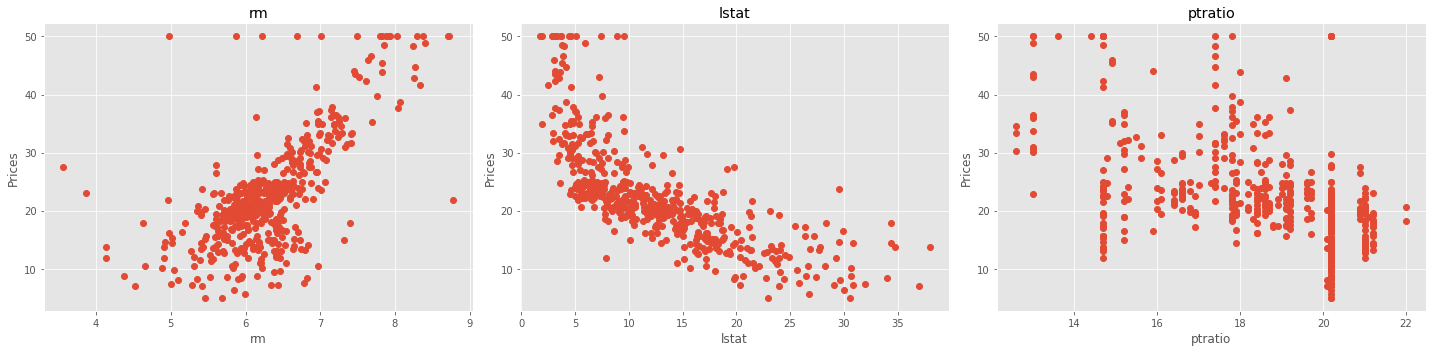

In [3]:
# __SOLUTION__ 
# Create scatter plots for each feature vs. target
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
for i, col in enumerate(features.columns):
    plt.subplot(1, 3, i+1)
    plt.plot(data[col], target, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Prices')
    plt.tight_layout()

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return the r-squared score and MSE for two equal sized arrays for the given true and predicted values 

In [ ]:
# Import metrics


# Define the function
def performance(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the r2 score between 'y_true' and 'y_predict'
    
    
    # Calculate the mean squared error between 'y_true' and 'y_predict'
    
    
    # Return the score
    
    pass


# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.4719999999999998]

In [4]:
# __SOLUTION__ 
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error 

# Define the function
def performance(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)
    
    # Calculate the mean squared error between 'y_true' and 'y_predict'
    mse = mean_squared_error(y_true, y_predict)
    
    # Return the score
    return [r2, mse]

# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score
# [0.9228556485355649, 0.4719999999999998]

[0.9228556485355649, 0.4719999999999998]

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [ ]:
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
x_train, x_test, y_train, y_test = None

In [5]:
# __SOLUTION__ 
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [ ]:
# Import DecisionTreeRegressor


# Instantiate DecisionTreeRegressor 
regressor = None

# Fit the model to training data


# Make predictions on the test data
y_pred = None

# Calculate performance using the performance() function 
score = None
score

# [0.47097115950374013, 38.795686274509805]  - R2, MSE

In [6]:
# __SOLUTION__ 
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
regressor = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(x_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

# [0.47097115950374013, 38.795686274509805]  - R2, MSE

[0.47097115950374013, 38.795686274509805]

## Hyperparameter tuning (I)

- Find the best tree depth for a depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate MSE and r-squared for each run 
- Plot both performance measures, for all runs 
- Comment on the output 

In [ ]:
# Your code here 

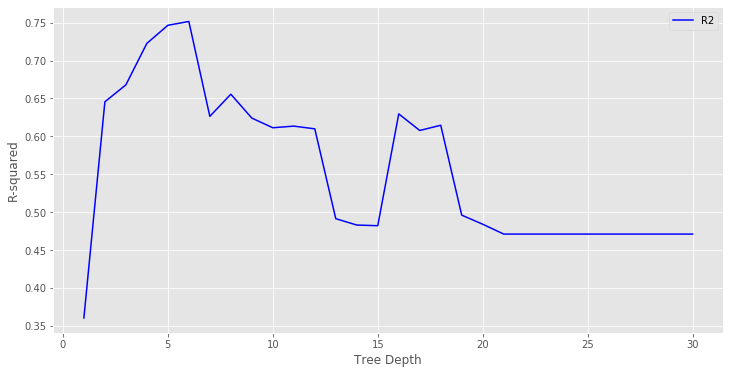

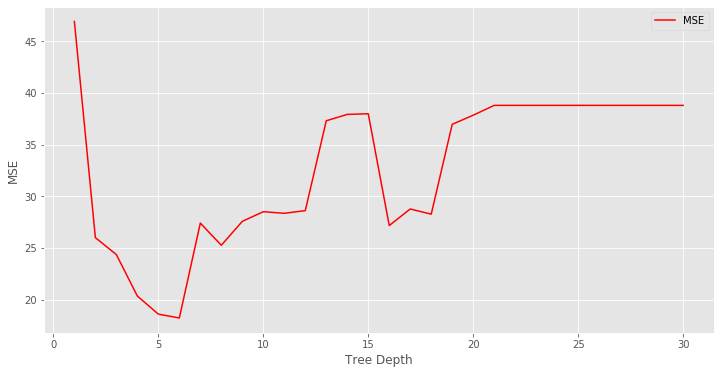

In [7]:
# __SOLUTION__ 
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 30, 30, endpoint=True)
mse_results = []
r2_results = []

for max_depth in max_depths:
    regressor = DecisionTreeRegressor(max_depth=max_depth, random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(max_depths, r2_results, 'b', label='R2')
plt.xlabel('Tree Depth')
plt.ylabel('R-squared')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(max_depths, mse_results, 'r', label='MSE')
plt.xlabel('Tree Depth')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

In [ ]:
# Your code here 

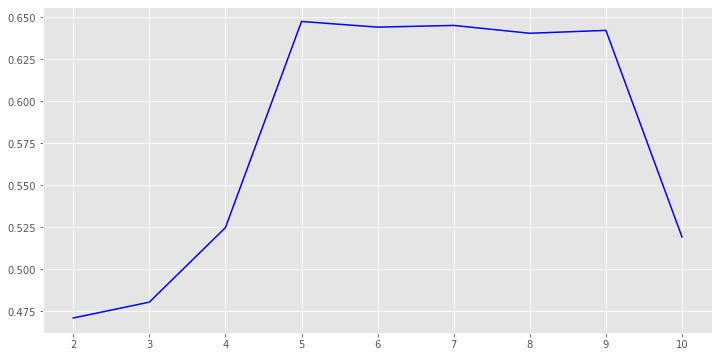

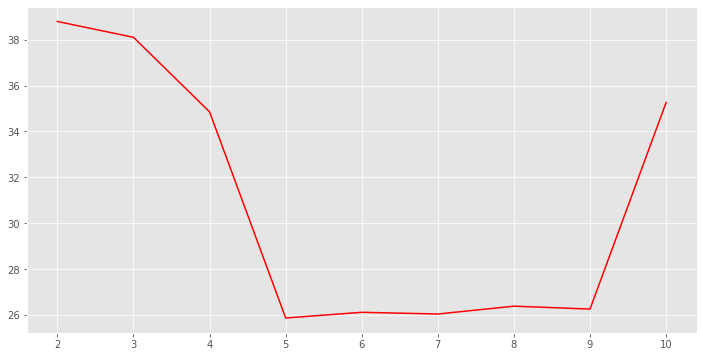

In [8]:
# __SOLUTION__ 
# Identify the optimal minimum split size for given data
min_samples_splits = np.arange(2, 11)
mse_results = []
r2_results = []

for min_samples_split in min_samples_splits:
    regressor = DecisionTreeRegressor(min_samples_split=int(min_samples_split), random_state=45)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)
    score = performance(y_test, y_pred)
    r2_results.append(score[0])
    mse_results.append(score[1])

plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, r2_results, 'b', label='R2')
plt.show()
plt.figure(figsize=(12, 6))
plt.plot(min_samples_splits, mse_results, 'r', label='MSE')
plt.show()

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [ ]:
# Your code here 

In [9]:
# __SOLUTION__ 
regressor = DecisionTreeRegressor(min_samples_split=5, max_depth=6, random_state=45)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
score = performance(y_test, y_pred)
score[0], score[1], regressor

(0.7515894043185498,
 18.216888758430127,
 DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=45, splitter='best'))

## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like max-features to find the optimal version of the model 

## Summary 

In this lab, we looked at applying a decision tree based regression analysis on the Boston Housing dataset. We saw how to train various models to find the optimal values for hyperparameters. 